In [1]:
import msrvxc
import numpy as np
import pickle

import matplotlib.pyplot as plt
from tqdm import tqdm

from astroquery.sdss import SDSS
from astroquery.gaia import Gaia

In [2]:
#wvl, raw_values, interp_bosz, interp_bosz_norm = msrvxc.build.build_bosz_grid(wl_range = [3600, 9000])

In [3]:
#with open('grids/interp_bosz_norm.pkl', 'wb') as f:
#    pickle.dump(interp_bosz_norm, f)
#    
#with open('grids/interp_bosz.pkl', 'wb') as f:
#    pickle.dump(interp_bosz, f)
#    
#np.save('grids/wavl.npy',wvl)

In [4]:
with open('grids/interp_bosz.pkl', 'rb') as f:
    interp_bosz = pickle.load(f)
    
with open('grids/interp_bosz_norm.pkl', 'rb') as f:
    interp_bosz_norm = pickle.load(f)
    
wvl = np.load('grids/wavl.npy')

In [5]:
print(len(wvl))

18326


In [6]:
params = (4999.848788360524,
3.812724027560155,
0.4084144628961131,
0.5593886093528815)

print(len(interp_bosz_norm(params)))

18326


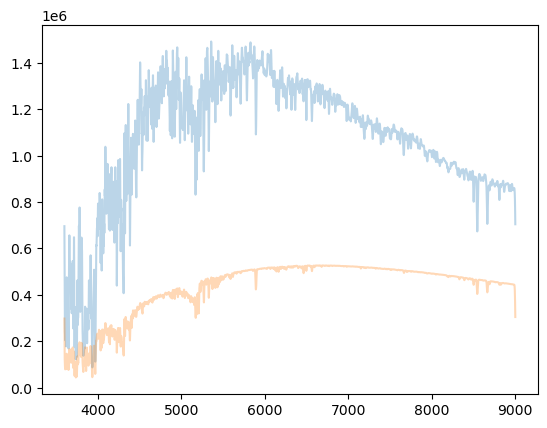

In [7]:


plt.plot(wvl, interp_bosz(params), alpha = 0.3)
plt.plot(wvl, interp_bosz((4213, 4.6, -2.3, 0)), alpha = 0.3)

In [8]:
import msrvxc


#params, rvgrid, cc = msrvxc.fit.fit_rv(interp_bosz_norm, wvl, wvl, interp_bosz_norm((4213, 4.1, -2.3, -40)))



In [9]:
#fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
#samples = sampler.get_chain()
#labels = ["Teff", "logg", "Z", "rv"]
#for i in range(ndim):
#    ax = axes[i]
#    ax.plot(samples[:, :, i], "k", alpha=0.3)
#    ax.set_xlim(0, len(samples))
#    ax.set_ylabel(labels[i])
#    ax.yaxis.set_label_coords(-0.1, 0.5)
#
#axes[-1].set_xlabel("step number");

In [10]:
#flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
#print(flat_samples.shape)

In [11]:
#import corner
#
#fig = corner.corner(
#    flat_samples, labels=labels, truths=[4213, 4.1, -2.3, 0]
#);

In [12]:
#X = np.median(flat_samples,axis=0)
#T, logg, Z, rv = X[:4]
#
#print(T, logg, Z, rv)

In [13]:
from astropy.table import Table, vstack

catalog = Table.read('../gravitational-redshift/data/00_raw.fits')
dat = Table()

dat['sourceid'] = catalog['ms_source_id']

In [14]:
stardats = []
teffs = np.linspace(2000, 7000, 10)

for i in tqdm(range(len(teffs)-1)):
    try:
        GAIA_ADQL = """SELECT gaia.radial_velocity, gaia.radial_velocity_error, sdss.original_ext_source_id as bestobjid, gaia.rv_template_teff, gaia.rv_template_logg
            FROM gaiadr3.gaia_source as gaia
            JOIN gaiaedr3.sdssdr13_best_neighbour as sdss
            ON gaia.source_id = sdss.source_id      
            WHERE gaia.radial_velocity is not null AND
            gaia.rv_template_teff BETWEEN {:f} AND {:f} AND
            gaia.rv_template_logg BETWEEN 2.5 AND 5""".format(teffs[i], teffs[i+1])
        
        job1 = Gaia.launch_job(GAIA_ADQL,dump_to_file=False)
        stardats.append(job1.get_results())
    except:
        pass
d1 = vstack(stardats)

100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:31<00:00, 16.86s/it]


In [15]:
teffs

array([2000.        , 2555.55555556, 3111.11111111, 3666.66666667,
       4222.22222222, 4777.77777778, 5333.33333333, 5888.88888889,
       6444.44444444, 7000.        ])

In [16]:
d1

radial_velocity,radial_velocity_error,bestobjid,rv_template_teff,rv_template_logg
km / s,km / s,,K,log(cm.s**-2)
float32,float32,int64,float32,float32
-854.7091,3.8250768,1237666408455930043,3500.0,3.5
-853.3459,6.547986,1237667725904249127,3600.0,2.5
-799.1756,8.776021,1237680092189098368,3400.0,3.5
-728.174,11.205389,1237680076080677071,3400.0,3.5
-711.1589,6.764356,1237646793310930128,3600.0,4.5
-502.8336,6.594078,1237670445149914885,3500.0,3.0
-500.8923,8.632132,1237678617412632669,3500.0,4.0
-449.52213,6.989473,1237678619023442213,3600.0,4.5


In [17]:
stardats = []
iters = len(d1) // 100

for i in tqdm(range(iters)):
    SDSS_QUERY = """select bestObjID as bestobjid, plate, mjd, fiberID
        from dbo.SpecObjAll
        where bestObjID in {}""".format(tuple(d1['bestobjid'][100*i:100*i+100]))
    try:
        f = SDSS.query_sql(SDSS_QUERY)
        if f is not None:
            stardats.append(SDSS.query_sql(SDSS_QUERY))
    except:
        pass
spec = vstack(stardats)

100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 332.62it/s]


In [18]:
from astropy.table import Table, join

data = join(spec, d1, keys = 'bestobjid')
data

bestobjid,plate,mjd,fiberID,radial_velocity,radial_velocity_error,rv_template_teff,rv_template_logg
,,,,km / s,km / s,K,log(cm.s**-2)
int64,int64,int64,int64,float32,float32,float32,float32
1237646792236271137,7258,56605,699,-158.48367,9.908892,6500.0,3.0
1237648674512109600,2901,54652,482,-256.40887,7.6573806,5250.0,3.0
1237651250958237766,2882,54498,506,-104.10134,5.7755647,3300.0,4.5
1237651271361495156,2858,54464,95,-279.16104,4.925107,5250.0,4.0
1237651271361495156,2858,54498,90,-279.16104,4.925107,5250.0,4.0
1237651272976826381,2445,54573,349,-200.85895,4.83569,6500.0,4.0
1237651273503277100,2383,53800,314,-348.5674,4.026336,5000.0,3.5
1237651537636294677,2858,54464,139,-78.94384,7.1684475,6750.0,4.0


In [19]:
from Payne import utils as payne_utils

c_kms = 2.99792458e5 # speed of light in km/s

def simulate_spec(interpolator, interp_wvl, wl, params):
    teff, logg, Z, rv = (params['teff'], params['logg'], params['z'], params['RV'])
    
    wl = wl * np.sqrt((1 - rv/c_kms)/(1 + rv/c_kms))
    
    return payne_utils.smoothing.smoothspec(wl, np.interp(wl, interp_wvl, interpolator( (teff, logg, Z, 0) )), resolution = 3000, smoothtype="R")

def continuum_normalize(wl, fl, ivar = None, avg_size = 150, ret_cont = False):
    
    fl_norm = np.zeros(np.size(fl))
    fl_cont = np.zeros(np.size(fl))
    
    ivar_yes = 0
    if ivar is not None:
        ivar_yes = 1
        ivar_norm = np.zeros(np.size(fl))
        
    for i in range(np.size(wl)):
        wl_clip = ((wl[i]-avg_size/2)<wl) * (wl<(wl[i]+avg_size/2))
        fl_cont[i] = np.median(fl[wl_clip])
        if ivar_yes:
            ivar_norm[i] = ivar[i]*np.median(fl[wl_clip])**2
    
    fl_norm = fl/fl_cont
    
    if ret_cont:
        if ivar_yes:
            return wl, fl_norm, ivar_norm, fl_cont
        else:
            return wl, fl_norm, fl_cont
    else:
        if ivar_yes:
            return wl, fl_norm, ivar_norm
        else:
            return wl, fl_norm

In [23]:
ms_rv = []
ms_e_rv = []
drops = []

for i in tqdm(range(len(data))):
    try:
        spec = SDSS.get_spectra(plate=data['plate'][i], fiberID=data['fiberID'][i], mjd=data['mjd'][i])[0]
    
        wl = (10**spec[1].data['loglam'])
        fl = (spec[1].data['flux'])
        ivar = (spec[1].data['ivar'])
        
        wl, fl, ivar = continuum_normalize(wl, fl, ivar)
        
        mask = (4500 < wl)*(wl < 5500)
        
        res, rv, e_rv, rvgrid, cc = msrvxc.fit.fit_rv(interp_bosz_norm, wvl, wl, fl, ivar, plot = False)
        
        ms_rv.append(rv)
        ms_e_rv.append(e_rv)
    except:
        drops.append(i)
    
    
    
data.remove_rows(drops)

100%|█████████████████████████████████████████████████████████████████████████████████| 157/157 [26:01<00:00,  9.95s/it]


In [29]:
print(len(ms_rv))

151


Text(0, 0.5, 'RV (Gaia) $[km/s]$')

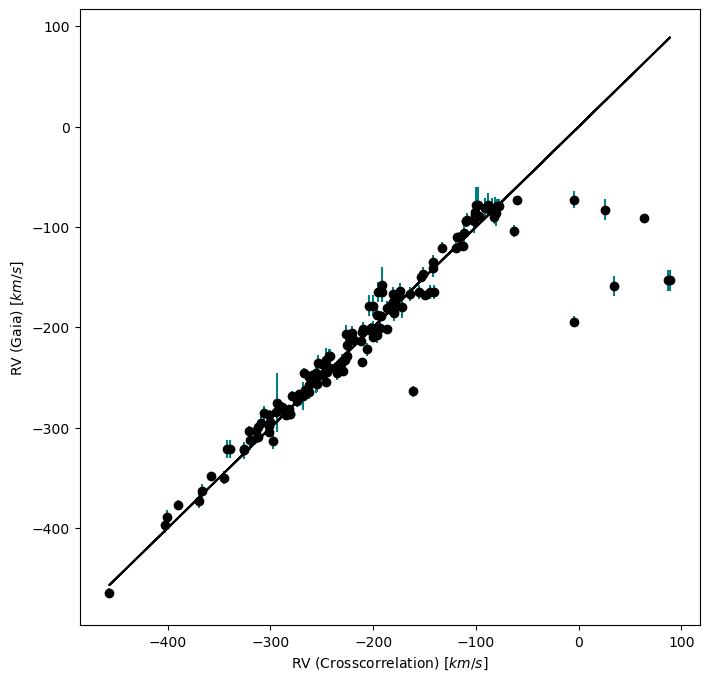

In [27]:
def linear(x):
    return x

plt.figure(figsize=(8,8))
#plt.style.use('stefan.mplstyle')

plt.errorbar(ms_rv, data['radial_velocity'], xerr = ms_e_rv, yerr = data['radial_velocity_error'],
             fmt='o', label = 'Data', color='black', ecolor = 'teal')
plt.plot(ms_rv, linear(ms_rv), color = 'black')

#plt.text(50, -20, 'MAE = {:2.1f} km/s'.format(mae))
#plt.text(50, -40, 'Bias = {:2.1f} km/s'.format(bias))

ymin, ymax = plt.ylim()
plt.xlabel(r'RV (Crosscorrelation) $[km/s]$')
plt.ylabel(r'RV (Gaia) $[km/s]$')

In [28]:
rmse = 0
mae = 0
for i in range(len(data['radial_velocity'])):
    rmse += (data['radial_velocity'][i] - ms_rv[i])**2
    mae += np.abs(data['radial_velocity'][i] - ms_rv[i])
    
rmse = np.sqrt( rmse / len(data['radial_velocity']))
mae = mae / len(data['radial_velocity'])
bias = np.average(data['radial_velocity'] - ms_rv)

print('rmse: {:2.1f} km/s'.format(rmse))
print('mae: {:2.1f} km/s'.format(mae))
print('bias: {:2.1f} km/s'.format(bias))

rmse: 41.5 km/s
mae: 17.3 km/s
bias: -4.6 km/s


In [ ]:
i = 0

spec = SDSS.get_spectra(plate=data['plate'][i], fiberID=data['fiberID'][i], mjd=data['mjd'][i])[0]

wl = (10**spec[1].data['loglam'])
fl = (spec[1].data['flux'])
ivar = (spec[1].data['ivar'])

wl, fl, ivar = continuum_normalize(wl, fl, ivar)

mask = (4500 < wl)*(wl < 5500)

res, rv, e_rv, rvgrid, cc, param_grid = msrvxc.fit.fit_rv(interp_bosz_norm, wvl, wl, fl, ivar, plot = False)

print("RV: {:3.1f} \n Teff: {:4f} \n logg {:2.3f}".format(rv, res.params['teff'].value, res.params['logg'].value))
print(res.params['RV'])

In [ ]:
cutoff = 1
t_cc = np.interp(rv, rvgrid, cc)
temp = np.array([(cc[i] - t_cc) < cutoff for i in range(len(cc))])

In [ ]:
plt.figure(figsize = (10,5))
pcoef = np.polyfit(rvgrid, cc, 2)
plt.plot(rvgrid, cc)
plt.plot(rvgrid[temp], cc[temp])

In [ ]:
print(np.abs(min(rvgrid[temp]) -max(rvgrid[temp])) / 2)

In [ ]:
new_param_grid = np.array(param_grid).T
tmask = ~np.all([new_param_grid[-2] < -1500, new_param_grid[-2] > -1500], axis = 0)

print(np.std(new_param_grid[-2]))

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.hist(new_param_grid[-2], bins = 10)
plt.axvline(x = rv, c = 'black')
plt.axvline(x = rv + e_rv, c = 'black')
plt.axvline(x = rv - e_rv, c = 'black')
plt.xlabel('rv')
         
plt.subplot(1,3,2)
plt.hist(new_param_grid[0])
plt.xlabel('Teff')
         
plt.subplot(1,3,3)
plt.hist(new_param_grid[1])
plt.xlabel('logg')

In [ ]:
print(param_grid[3])

In [ ]:
plt.hist()

In [ ]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)

res.params['RV'].value = rv

plt.plot(wl[mask], msrvxc.utils.continuum_normalize(wl, fl)[1][mask], label = 'Observed')
plt.plot(wl[mask], simulate_spec(interp_bosz_norm, wvl, wl, res.params)[mask], alpha = 1, label = 'Model')

plt.legend()

plt.subplot(1,2,2)

plt.scatter(rvgrid, cc, s = 1)
plt.axvline(x=data['radial_velocity'][i])

plt.xlabel('RV')
plt.ylabel('chi2')

In [ ]:
plt.figure(figsize = (15,5))

mask = (4500 < wl)*(wl < 5500)

plt.plot(wl[mask], msrvxc.utils.continuum_normalize(wl, fl)[1][mask], label = 'Observed')
plt.plot(wl[mask], simulate_spec(interp_bosz_norm, wvl, wl, res.params)[mask], alpha = 1, label = 'Model')

res.params['RV'].value = -348.5674

print(res.params)

#plt.plot(wl[mask], simulate_spec(interp_bosz_norm, wvl, wl, res.params)[mask], alpha = 1, label = 'Model With RV Forced Correct')

plt.legend()